<a href="https://colab.research.google.com/github/DevSingh28/DCGAN_IMAGE_GENERATOR/blob/main/GAN_Image_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Start with Dataset (Downloading the anime face image dataset which contain more than 63k images (More the image better the results))

!kaggle datasets download -d geetmukherjee/anime-image-dataset-deep-learning
!unzip anime-image-dataset-deep-learning -d image_data

Streaming output truncated to the last 5000 lines.
  inflating: image_data/images/62764_2019.jpg  
  inflating: image_data/images/62765_2019.jpg  
  inflating: image_data/images/62766_2019.jpg  
  inflating: image_data/images/62767_2019.jpg  
  inflating: image_data/images/62768_2019.jpg  
  inflating: image_data/images/62769_2019.jpg  
  inflating: image_data/images/6276_2003.jpg  
  inflating: image_data/images/62770_2019.jpg  
  inflating: image_data/images/62771_2019.jpg  
  inflating: image_data/images/62772_2019.jpg  
  inflating: image_data/images/62773_2019.jpg  
  inflating: image_data/images/62774_2019.jpg  
  inflating: image_data/images/62775_2019.jpg  
  inflating: image_data/images/62776_2019.jpg  
  inflating: image_data/images/62777_2019.jpg  
  inflating: image_data/images/62778_2019.jpg  
  inflating: image_data/images/62779_2019.jpg  
  inflating: image_data/images/6277_2003.jpg  
  inflating: image_data/images/62780_2019.jpg  
  inflating: image_data/images/62781_20

In [ ]:
# Checking if their any error image in the dataset ?

import os
from PIL import Image

def remove_corrupted_images(data_dir):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except (IOError, SyntaxError):
                    print(f"Removing corrupted image: {file_path}")
                    os.remove(file_path)


remove_corrupted_images('/content/Images_Dir3/image_data')


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


(91, 91)
(97, 97)
(114, 114)
(62, 62)
(86, 86)


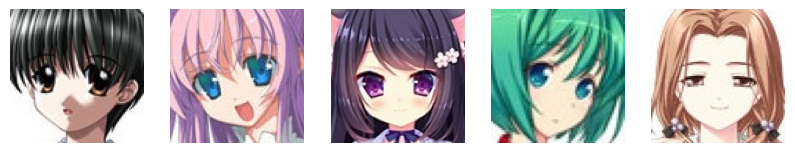

In [ ]:
## Function to visualize images:

import os
from PIL import Image

data_dir = '/content/Images_Dir3/image_data'

image_paths = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

def display_images(image_paths, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        img = Image.open(image_paths[i])
        plt.subplot(1, num_images, i + 1)
        print(f"{img.size}")
        plt.imshow(img)
        plt.axis('off')
    plt.show()

display_images(image_paths, num_images=5)


In [ ]:
# Transforming the images (resizing them to 64, normalizing and turining images to tensor)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Loading the images using DataLoader and using batch size of 64

dataset = datasets.ImageFolder(root='/content/Images_Dir3', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
# Hyperparameters

learning_rate = 0.00005
latent_dim = 64
image_size = 128
num_channels = 3
num_epochs = 12

In [ ]:
# Generater Class (This class will generate images based on random noise)

class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Discriminator class (This will try to identify if the image passed to it is real or fake)

class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)


In [ ]:
# Creating instance , optimizer and loss_function

generator = DCGAN_Generator().to(device)
discriminator = DCGAN_Discriminator().to(device)

loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate * 0.5, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [ ]:
# Initilizing weights for better results

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

DCGAN_Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
# Function to show the generated images

def generate_and_show_images(generator):
    torch.manual_seed(42)
    z = torch.randn(64, latent_dim, 1, 1).to(device)

    fake_images = generator(z).detach().cpu()
    fake_images = (fake_images + 1) / 2

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.transpose(fake_images[i], (1, 2, 0)))
        ax.axis('off')
    plt.show()

In [ ]:
# Total number of batches

len(dataloader)

994

Epoch 1/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [1/12], d_loss: 0.5650986433029175, g_loss: 2.843775987625122


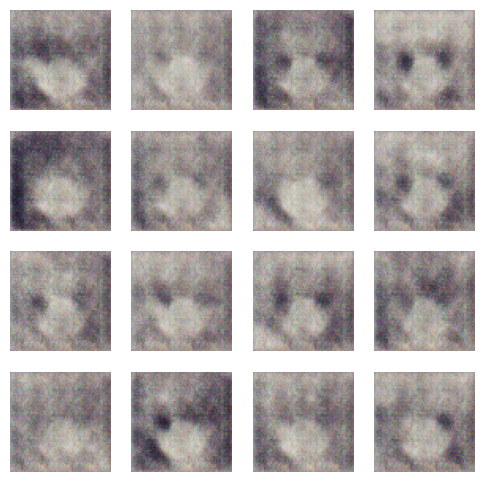

Epoch 2/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [2/12], d_loss: 0.5862419009208679, g_loss: 2.555863618850708


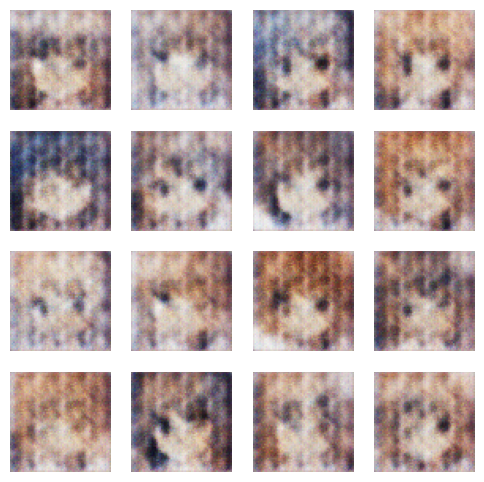

Epoch 3/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [3/12], d_loss: 0.6271967887878418, g_loss: 3.969233989715576


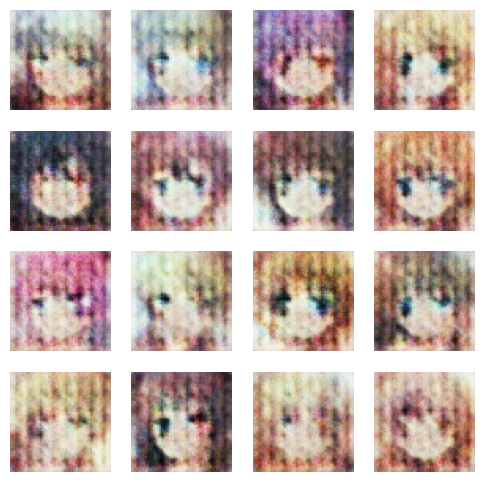

Epoch 4/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [4/12], d_loss: 0.6078915596008301, g_loss: 2.8470277786254883


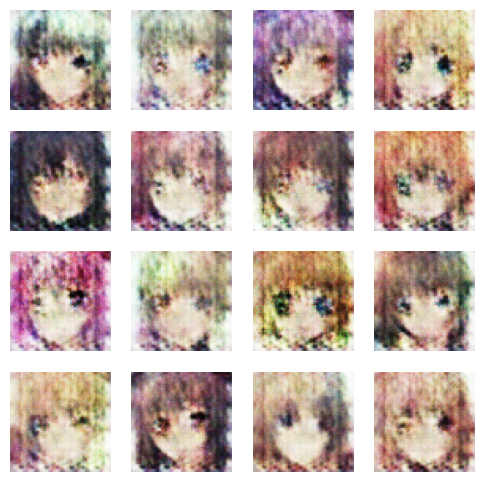

Epoch 5/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [5/12], d_loss: 0.8097572326660156, g_loss: 5.22929573059082


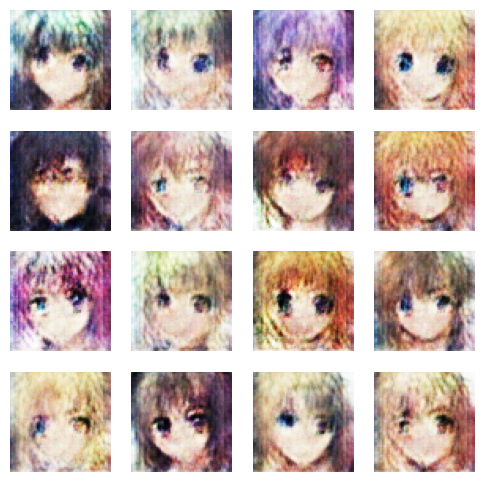

Epoch 6/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [6/12], d_loss: 0.6021091938018799, g_loss: 2.5086233615875244


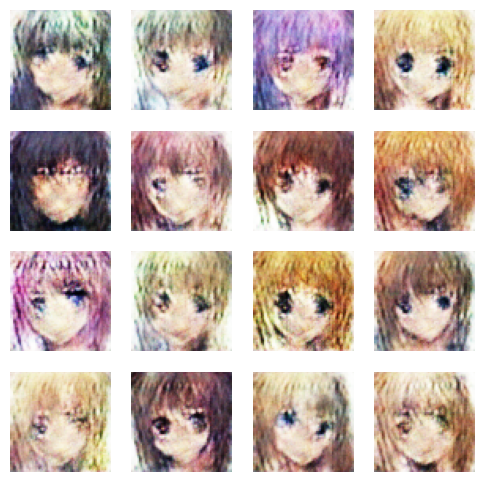

Epoch 7/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [7/12], d_loss: 0.5797788500785828, g_loss: 3.230811595916748


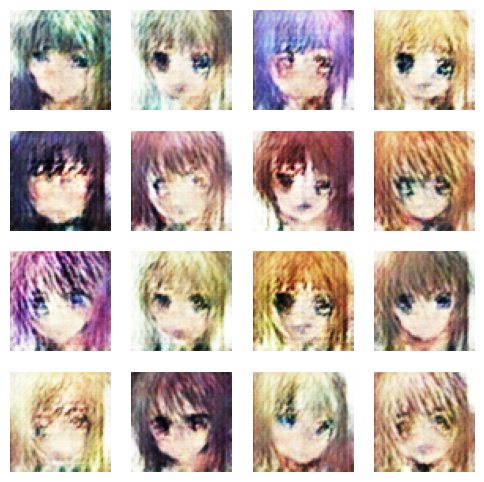

Epoch 8/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [8/12], d_loss: 0.5814826488494873, g_loss: 2.9317305088043213


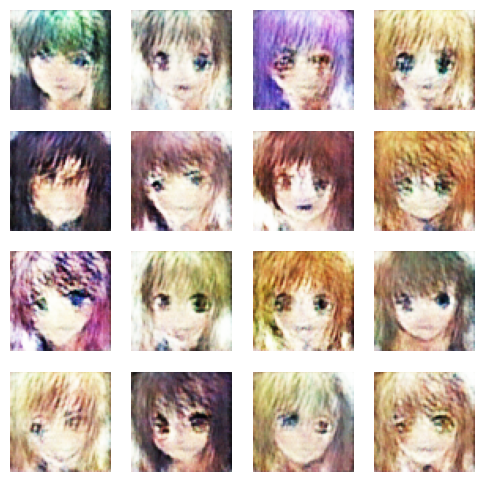

Epoch 9/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [9/12], d_loss: 0.5972920060157776, g_loss: 3.312080144882202


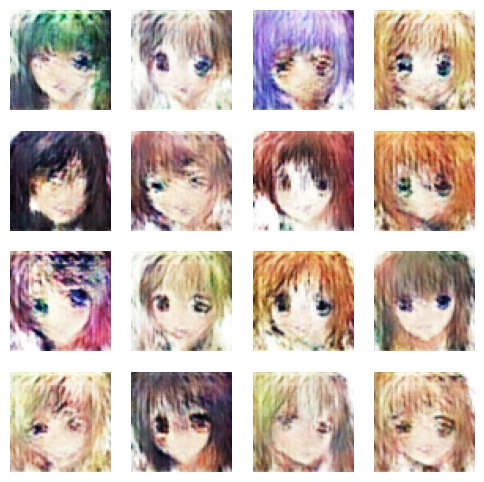

Epoch 10/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [10/12], d_loss: 0.5926508903503418, g_loss: 2.9819588661193848


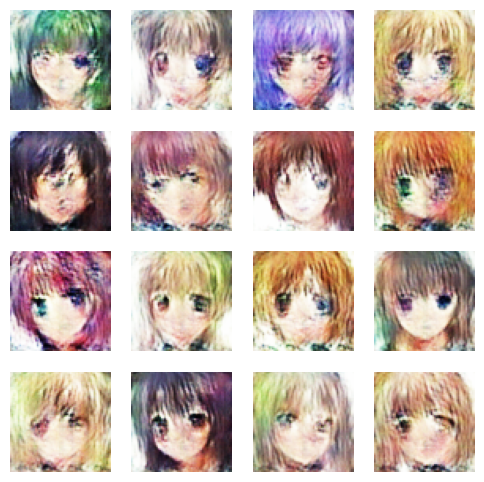

Epoch 11/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [11/12], d_loss: 0.5792676210403442, g_loss: 2.4697718620300293


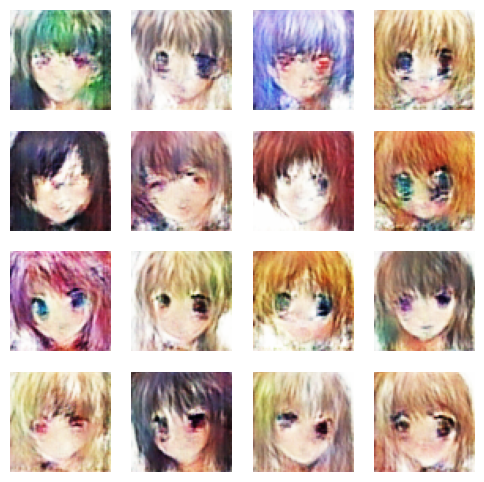

Epoch 12/12:   0%|          | 0/994 [00:00<?, ?it/s]

Epoch [12/12], d_loss: 0.7049312591552734, g_loss: 3.8910906314849854


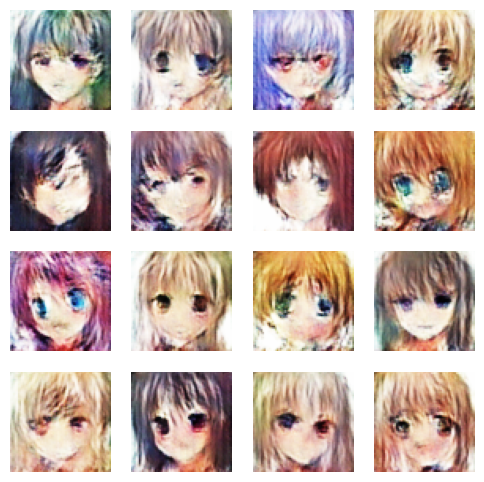

In [ ]:
# Let's start the training of the model (I am only training for 12 epochs due to limited resources...)

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for real_images, _ in progress_bar:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device) * 0.9
        fake_labels = torch.zeros(batch_size, 1).to(device) + 0.1 * torch.rand(batch_size, 1).to(device)

        # Train Discriminator

        optimizer_D.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = loss_fn(outputs, real_labels)

        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = loss_fn(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = loss_fn(outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

        progress_bar.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
    generate_and_show_images(generator)

In [ ]:
torch.save(generator.state_dict(), "dcgan_generator.pth")
torch.save(discriminator.state_dict(), "dcgan_discriminator.pth")